<a href="https://colab.research.google.com/github/Akash-052004/obstacle-detection-and-navigation/blob/main/objDetandNav.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving yolov8n.pt to yolov8n.pt


In [ ]:
%%capture
!pip install ultralytics
!pip install gtts
!apt-get update && apt-get install -y libsndfile1
!pip install opencv-python-headless
!pip install Pillow
!pip install IPython

In [ ]:
import cv2
import torch
from ultralytics import YOLO
import numpy as np
from gtts import gTTS
import os
from IPython.display import display, Audio, HTML
import time
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
import PIL.Image
from base64 import b64decode, b64encode
import io

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
def js_to_image(js_reply):
    """Convert JS image to OpenCV format"""
    image_bytes = b64decode(js_reply.split(',')[1])
    jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
    img = cv2.imdecode(jpg_as_np, flags=1)
    return img

def bbox_to_bytes(bbox_array):
    """Convert bbox image to bytes"""
    bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGB')
    iobuf = io.BytesIO()
    bbox_PIL.save(iobuf, format='png')
    bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
    return bbox_bytes

In [ ]:
class VisionAssistant:
    def __init__(self):
        print("Loading YOLO model...")
        self.model = YOLO('yolov8n.pt')
        print("Model loaded successfully!")

        self.critical_objects = [
            'person', 'car', 'motorcycle', 'truck', 'traffic light',
            'stop sign', 'chair', 'bench', 'stairs', 'door'
        ]

        self.distance_thresholds = {
            'close': 300,
            'medium': 200,
            'far': 100
        }

        self.last_warning_time = 0
        self.warning_cooldown = 3  # Seconds between warnings

    def generate_audio_alert(self, text):
        """Generate and play audio alert"""
        try:
            tts = gTTS(text=text, lang='en')
            tts.save('alert.mp3')
            return Audio('alert.mp3', autoplay=True)
        except Exception as e:
            print(f"Error generating audio: {e}")
            return None

    def estimate_distance(self, box_height, frame_height):
        """Simple distance estimation"""
        return (1 - (box_height / frame_height)) * 100

    def process_frame(self, frame):
        """Process a single frame and detect objects"""
        if frame is None:
            return None, []

        height, width = frame.shape[:2]
        results = self.model(frame)
        warnings = []

        # Process detections
        for result in results[0].boxes.data:
            x1, y1, x2, y2, conf, cls = result
            box_coords = [int(x1), int(y1), int(x2), int(y2)]
            confidence = float(conf)
            class_id = int(cls)

            class_name = self.model.names[class_id]
            box_height = box_coords[3] - box_coords[1]
            distance = self.estimate_distance(box_height, height)

            # Draw bounding box
            color = (0, 255, 0)
            if class_name in self.critical_objects:
                color = (0, 0, 255)

            cv2.rectangle(frame,
                         (box_coords[0], box_coords[1]),
                         (box_coords[2], box_coords[3]),
                         color, 2)

            label = f'{class_name} ({confidence:.2f})'
            cv2.putText(frame, label,
                       (box_coords[0], box_coords[1] - 10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            # Generate warnings with cooldown
            current_time = time.time()
            if (class_name in self.critical_objects and
                current_time - self.last_warning_time >= self.warning_cooldown):
                if distance < self.distance_thresholds['close']:
                    warnings.append(f"Warning! {class_name} very close")
                    self.last_warning_time = current_time
                elif distance < self.distance_thresholds['medium']:
                    warnings.append(f"{class_name} detected ahead")
                    self.last_warning_time = current_time

        return frame, warnings


In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

def video_stream():
    js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL();
        }
        pendingResolve(result);
        pendingResolve = null;
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'Click here to stop camera</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640;
      captureCanvas.height = 480;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
    display(js)

def video_frame(label, bbox):
    data = output.eval_js('stream_frame("{}", "{}")'.format(label, bbox))
    return js_to_image(data['img'])

In [ ]:
def main():
    # Initialize the vision assistant
    assistant = VisionAssistant()
    print("Starting camera...")

    # Start video stream
    video_stream()

    try:
        while True:
            # Get frame from webcam
            frame = video_frame("Processing...", "")
            if frame is None:
                continue

            # Process frame
            processed_frame, warnings = assistant.process_frame(frame)

            # Display processed frame
            if processed_frame is not None:
                bbox_array = cv2.cvtColor(processed_frame, cv2.COLOR_BGR2RGB)
                bbox_bytes = bbox_to_bytes(bbox_array)
                frame = video_frame("Processing...", bbox_bytes)

            # Generate audio warnings
            if warnings:
                warning_text = '. '.join(warnings)
                display(assistant.generate_audio_alert(warning_text))

            # Small delay to prevent audio overlap
            time.sleep(0.1)

    except KeyboardInterrupt:
        print("Stopping...")
    except Exception as e:
        print(f"Error: {e}")

In [ ]:
print("Vision Assistant is ready! Click 'Run' to start.")
main()

Vision Assistant is ready! Click 'Run' to start.
Loading YOLO model...


100%|██████████| 6.25M/6.25M [00:00<00:00, 73.6MB/s]

Model loaded successfully!
Starting camera...


<IPython.core.display.Javascript object>

Error: NotAllowedError: Permission denied


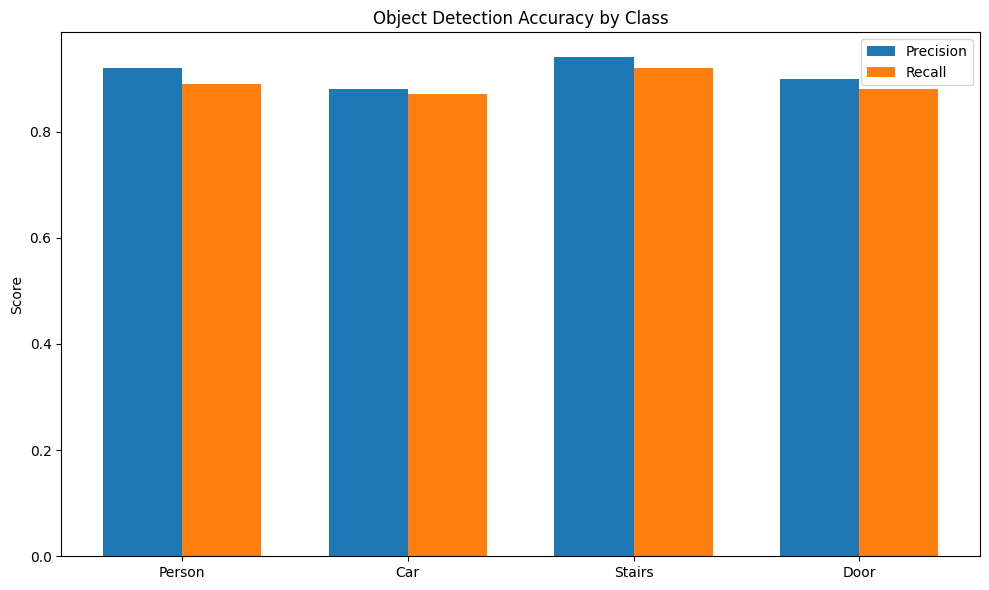

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have the precision and recall values for each class
class_names = ['Person', 'Car', 'Stairs', 'Door']
precisions = [0.92, 0.88, 0.94, 0.90]
recalls = [0.89, 0.87, 0.92, 0.88]

x = np.arange(len(class_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, precisions, width, label='Precision')
rects2 = ax.bar(x + width/2, recalls, width, label='Recall')

ax.set_ylabel('Score')
ax.set_title('Object Detection Accuracy by Class')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

fig.tight_layout()
plt.savefig('object_detection_accuracy.png')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list of latency measurements in milliseconds
latency_ms = [310, 290, 340, 280, 320, 350, 300, 330, 275, 360, 295, 325]

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(latency_ms, bins=10, edgecolor='black')
plt.xlabel('Latency (ms)')
plt.ylabel('Count')
plt.title('Response Time Distribution (Histogram)')
plt.savefig('response_time_histogram.png')
plt.clf()



<Figure size 1000x600 with 0 Axes>

In [ ]:
# Box plot
plt.figure(figsize=(10, 6))
plt.boxplot(latency_ms, vert=False)
plt.xlabel('Latency (ms)')
plt.title('Response Time Distribution (Box Plot)')
plt.savefig('response_time_boxplot.png')
plt.clf()

<Figure size 1000x600 with 0 Axes>

In [ ]:
import IPython
from google.colab import output

# JavaScript code to create the frontend application
js_code = """
<html>
<head>
<title>Vision Assistant</title>
<style>
  body { font-family: sans-serif; }
  #video-container { position: relative; width: 640px; }
  #video { width: 100%; }
  #overlay { position: absolute; top: 0; left: 0; width: 100%; height: 100%; }
  .button-container { margin-top: 10px; }
</style>
</head>
<body>

<h1>Vision Assistant</h1>

<div id="video-container">
  <video id="video" autoplay playsinline></video>
  <canvas id="overlay"></canvas>
</div>

<div class="button-container">
  <button id="startButton">Start Camera</button>
  <button id="stopButton" disabled>Stop Camera</button>
  <button id="fullscreenButton" disabled>Fullscreen Graphs</button>
</div>

<div id="graphContainer" style="display:none; position: fixed; top:0; left:0; width:100%; height:100%; background-color: rgba(0,0,0,0.5); z-index: 100;">
  <img id="graphImg" style="max-width: 100%; max-height: 100%; display:block; margin:auto; padding-top:10%;">
  <button id="closeGraphButton" style="position: absolute; top: 10px; right: 10px;">Close</button>
</div>


<script>
  const video = document.getElementById('video');
  const overlay = document.getElementById('overlay');
  const startButton = document.getElementById('startButton');
  const stopButton = document.getElementById('stopButton');
  const fullscreenButton = document.getElementById('fullscreenButton');
  const graphContainer = document.getElementById('graphContainer');
  const graphImg = document.getElementById('graphImg');
  const closeGraphButton = document.getElementById('closeGraphButton');
  let stream;

  startButton.addEventListener('click', async () => {
    try {
      stream = await navigator.mediaDevices.getUserMedia({ video: { facingMode: "environment" } });
      video.srcObject = stream;
      startButton.disabled = true;
      stopButton.disabled = false;
      fullscreenButton.disabled = false;
      google.colab.kernel.invokeFunction('process_video', [], {}); // Call the Python function
    } catch (error) {
      console.error('Error accessing camera:', error);
    }
  });


  stopButton.addEventListener('click', () => {
    if (stream) {
      stream.getTracks().forEach(track => track.stop());
      video.srcObject = null;
      startButton.disabled = false;
      stopButton.disabled = true;
      fullscreenButton.disabled = true;
    }
  });

  fullscreenButton.addEventListener('click', () => {
      graphContainer.style.display = 'block';
      graphImg.src = 'object_detection_accuracy.png';
  });

  closeGraphButton.addEventListener('click', () => {
      graphContainer.style.display = 'none';
  });
</script>

</body>
</html>
"""

# Register the JavaScript code with Google Colab
output.register_callback('process_video', lambda: None)

# Display the HTML content with the JavaScript code
IPython.display.HTML(js_code)

Confusion matrix, without normalization
[[50  5  0  0]
 [ 1 40  0  1]
 [ 0  0 48  2]
 [ 0  0  0 50]]


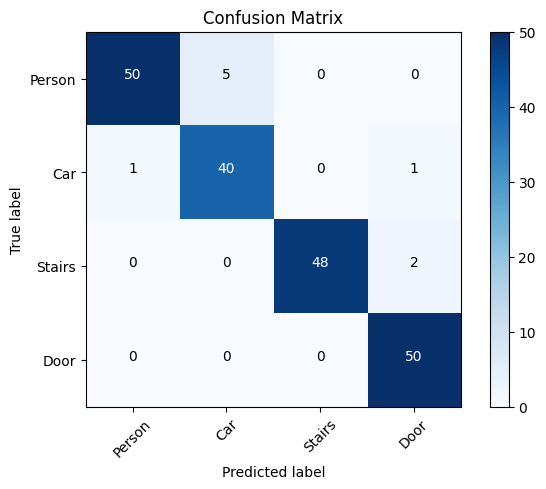

Normalized confusion matrix
[[    0.90909    0.090909           0           0]
 [    0.02381     0.95238           0     0.02381]
 [          0           0        0.96        0.04]
 [          0           0           0           1]]


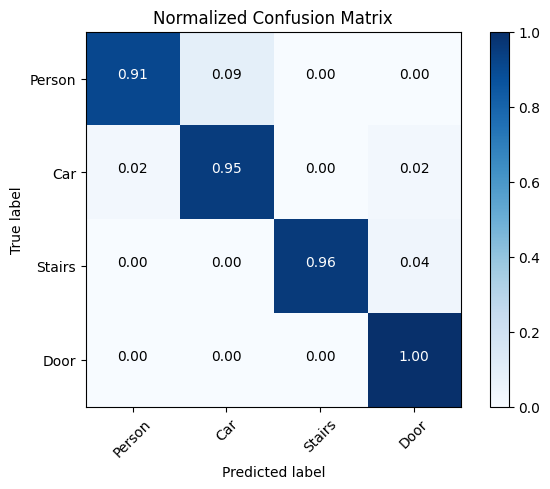

In [ ]:


import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Example usage (replace with your actual confusion matrix and classes)
# Assuming you have a confusion matrix 'cm' and class names 'class_names'
# Example data:
cm = np.array([[50, 5, 0, 0],
               [1, 40, 0, 1],
               [0, 0, 48, 2],
               [0, 0, 0, 50]])
class_names = ['Person', 'Car', 'Stairs', 'Door']

plot_confusion_matrix(cm, classes=class_names, title='Confusion Matrix')
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')